# Analysis on song degradation 

- Compare song features before and after deafening 
- Post-deafening songs were obtained from the last session where neural data are present 
- Use individual_syllable and syllable_pcc tables


In [190]:
from analysis.parameters import fr_crit, nb_note_crit
from database.load import ProjectLoader
from util import save
import pandas as pd
from util.draw import remove_right_top
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Load database
db = ProjectLoader().load_db()

In [191]:
def compare_song_feature_pre_post(db, song_feature):

    # Get song features from pre & post (Undir)
    query = f"""SELECT syl.birdID, syl.taskName, song.taskSessionPostDeafening, syl.note, syl.entropy, syl.entropyVar AS ev
                FROM individual_syllable syl INNER JOIN song
                ON song.id = syl.songID WHERE syl.context='U'
            """
    df = db.to_dataframe(query)

    # Get post-deafening where neural data are present
    query = \
        f"""SELECT birdID, taskName, taskSessionPostDeafening, note, nbNoteUndir AS nbNotes, entropyUndir AS entropy,  entropyVarUndir AS ev
            FROM syllable_pcc
            WHERE frUndir >= {fr_crit} AND nbNoteUndir >={nb_note_crit}
            AND taskName='Postdeafening'
            """
    df_pcc = db.to_dataframe(query)
    last_day_dict = df_pcc.groupby('birdID')['taskSessionPostDeafening'].max().to_dict()

    df_results = pd.DataFrame() # store results here

    for bird, last_day in last_day_dict.items():
        # if bird == 'b70r38':
        df_post = df.loc[(df['birdID']==bird) & (df['taskSessionPostDeafening']==last_day)]
        nb_notes_dict = df_post.groupby('note').size().to_dict()
        for note, nb_notes_post in nb_notes_dict.items():
            if nb_notes_post >= nb_note_crit:
                df_note_pre = df.loc[(df['birdID']==bird) &
                                (df['taskName']=='Predeafening') &
                                (df['note'] == note)
                                 ]
                nb_notes_pre = len(df_note_pre)
                if nb_notes_pre < nb_note_crit: continue
                # Subsample so that # of notes are equal between pre and post
                if nb_notes_pre < nb_notes_post:
                    pre_data, post_data = \
                        df_note_pre[song_feature].values, \
                        df_post.loc[df_post['note']==note].sample(n=nb_notes_pre, random_state=1)[song_feature].values
                else:
                    pre_data, post_data = \
                        df_note_pre.sample(n=nb_notes_post, random_state=1)[song_feature].values, \
                        df_post.loc[df_post['note'] == note][song_feature].values
                # print(len(pre_data), len(post_data))
                # print(f"{pre_data.mean() :.3f}, {post_data.mean() :.3f}")

                # rank-sum test (two-sample non-parametric test)
                from scipy.stats import ranksums
                if song_feature == 'entropy':
                    stat, pval = ranksums(pre_data, post_data, alternative='less')
                elif  song_feature == 'ev':
                    stat, pval = ranksums(pre_data, post_data, alternative='greater')

                # degree_of_freedom = len(pre_data) + len(pre_data) - 2
                # if pval < 0.001:  # mark significance
                #     msg = f"ranksum Z={stat : .3f}, p < 0.001"
                # else:
                #     msg = f"ranksum Z={stat : .3f}, p={pval : .3f}"

                # Organize results
                df_temp = pd.DataFrame({'birdID' : [bird],
                                        'note': [note],
                                        'nbNotes' : [len(pre_data)],
                                        song_feature + 'Pre': [round(pre_data.mean(), 3)],
                                        song_feature + 'Post': [round(post_data.mean(), 3)],
                                        'postSessionDeafening': [last_day],
                                        'sig': [pval<0.05],
                                        })
                df_results = df_results.append(df_temp, ignore_index=True)

    return df_results



In [192]:
def plot_song_feature_pre_post_stats(df, song_feature, x_lim=None, y_lim=None):

    # plot_song_feature_pre_post_stats
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from util.draw import remove_right_top

    # Loop through birds to plot all notes
    dot_size = 60
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    # Plot scatter
    sns.scatterplot(np.zeros(len(df)), df[song_feature + 'Pre'],
                    s=dot_size, color='k', ax=ax)

    sns.scatterplot(np.ones(len(df)) * df['postSessionDeafening'],
                    df[song_feature + 'Post'],
                    s=dot_size, color='k', ax=ax)


    for _, row in df.iterrows():
        color = 'm-' if row['sig'] else 'k-'  # mark significance in magenta
        ax.plot([0, row['postSessionDeafening']],
                [row[song_feature + 'Pre'], row[song_feature + 'Post']],
                color, linewidth=1)

    remove_right_top(ax)
    if x_lim:
        ax.set_xlim(x_lim)
    if y_lim:
        ax.set_ylim(y_lim)
    ax.set_xlabel('Days after deafening')
    ax.set_ylabel(song_feature)
    plt.suptitle(f"""Pre vs. Last day of neural recording after deafening \n
                    \n # of notes = {len(df)} ({df['sig'].sum()} /{len(df_results)})""", y=1, fontsize=10)
    plt.show()


## Entropy

• Marked syllables that changed differently from pre-deafening (magenta).

• 2-sample rank-sum test (one-tailed, alpha = 0.05).


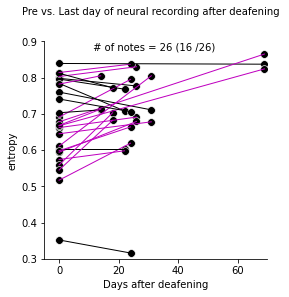

In [193]:
df_results = compare_song_feature_pre_post(db, song_feature='entropy')
plot_song_feature_pre_post_stats(df_results, song_feature='entropy',
                                 x_lim=[-5, 70], y_lim=[0.3, 0.9]
                                 )

## Entropy Variance

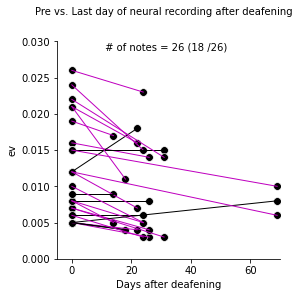

In [194]:
df_results = compare_song_feature_pre_post(db, song_feature='ev')
plot_song_feature_pre_post_stats(df_results, song_feature='ev',
                                 x_lim=[-5, 70], y_lim=[0, 0.03]
                                 )

In [195]:
# Get song features from pre & post (Undir)
query = f"""SELECT syl.birdID, syl.taskName, song.taskSessionPostDeafening, song.block10days, syl.note, syl.entropy, syl.entropyVar AS ev
            FROM individual_syllable syl INNER JOIN song
            ON song.id = syl.songID WHERE syl.context='U'
        """
df = db.to_dataframe(query)

In [196]:
# Get post-deafening where neural data are present
query = \
    f"""SELECT birdID, taskName, taskSessionPostDeafening, block10days, note, nbNoteUndir AS nbNotes, entropyUndir AS entropy,  entropyVarUndir AS ev
        FROM syllable_pcc
        WHERE frUndir >= {fr_crit} AND nbNoteUndir >={nb_note_crit}
        AND taskName='Postdeafening' 
        AND block10days=1
        """
df_pcc = db.to_dataframe(query)

In [197]:
df_pcc

,birdID,taskName,taskSessionPostDeafening,block10days,note,nbNotes,entropy,ev
0,b70r38,Postdeafening,10,1,a,29,0.479,0.02317
1,b70r38,Postdeafening,10,1,b,29,0.535,0.01186
2,b70r38,Postdeafening,10,1,c,29,0.797,0.01465
3,b70r38,Postdeafening,10,1,d,27,0.718,0.01374
4,w16w14,Postdeafening,4,1,a,161,0.826,0.00618
5,w16w14,Postdeafening,4,1,b,103,0.725,0.01644
6,w16w14,Postdeafening,4,1,c,97,0.686,0.01286
7,w16w14,Postdeafening,7,1,a,77,0.813,0.00657
8,w16w14,Postdeafening,7,1,b,50,0.737,0.01418
9,w16w14,Postdeafening,7,1,c,52,0.700,0.00981


In [198]:
df_post_block = df.loc[(df['birdID']=='b70r38') & (df['block10days']==1)]

nb_notes_dict = df_post_block.groupby(['taskSessionPostDeafening', 'note']).size().to_dict()
nb_notes_dict

{(7, 'a'): 30,
 (7, 'b'): 29,
 (7, 'c'): 28,
 (7, 'd'): 28,
 (10, 'a'): 29,
 (10, 'b'): 29,
 (10, 'c'): 29,
 (10, 'd'): 27}

In [199]:
song_feature = 'entropy'

def compare_song_feature_pre_post_per_block(db, song_feature):

    df_results = pd.DataFrame() # store results here

    birds = df['birdID'].unique()
    blocks = df['block10days'].unique()

    for block in blocks:

        if block == 0: continue  # skip if pre-deafening
        for bird in birds:
            # if bird != 'b70r38': continue

            df_post_block = df.loc[(df['birdID']==bird) & (df['block10days']==block)]
            nb_notes_dict = df_post_block.groupby(['taskSessionPostDeafening', 'note']).size().to_dict()

            for (day, note), nb_notes_post in nb_notes_dict.items():

                if nb_notes_post >= nb_note_crit:
                    df_pre = df.loc[(df['birdID']==bird) &
                                    (df['taskName']=='Predeafening') &
                                    (df['note'] == note)
                                     ]

                    df_post = df_post_block.loc[(df_post_block['note']==note) & (df_post_block['taskSessionPostDeafening']==day)]

                    nb_notes_pre = len(df_pre)
                    if nb_notes_pre < nb_note_crit: continue

                    # Subsample so that # of notes are equal between pre and post
                    if nb_notes_pre < nb_notes_post:
                        pre_data, post_data = \
                            df_pre[song_feature].values, \
                            df_post.sample(n=nb_notes_pre, random_state=1)[song_feature].values
                    else:
                        pre_data, post_data = \
                            df_pre.sample(n=nb_notes_post, random_state=1)[song_feature].values, \
                            df_post[song_feature].values

                    # print(len(pre_data), len(post_data))
                    # print(f"{pre_data.mean() :.3f}, {post_data.mean() :.3f}")

                    # rank-sum test (two-sample non-parametric test)
                    from scipy.stats import ranksums
                    if song_feature == 'entropy':
                        stat, pval = ranksums(pre_data, post_data, alternative='less')
                    elif  song_feature == 'ev':
                        stat, pval = ranksums(pre_data, post_data, alternative='greater')

                    # Organize results
                    df_temp = pd.DataFrame({'birdID' : [bird],
                                            'note': [note],
                                            'nbNotes' : [len(pre_data)],
                                            song_feature + 'Pre': [round(pre_data.mean(), 3)],
                                            song_feature + 'Post': [round(post_data.mean(), 3)],
                                            'postSessionDeafening': [day],
                                            'block10days': [block],
                                            'sig': [pval<0.05],
                                            })
                    df_results = df_results.append(df_temp, ignore_index=True)
    return df_results

In [200]:
df_results = compare_song_feature_pre_post_per_block(db, song_feature='entropy')
df_results.head()
# df_results['sig'].sum()/len(df_results)

,birdID,note,nbNotes,entropyPre,entropyPost,postSessionDeafening,block10days,sig
0,b70r38,a,30,0.785,0.665,7,1,False
1,b70r38,b,29,0.613,0.650,7,1,True
2,b70r38,c,28,0.792,0.752,7,1,False
3,b70r38,d,28,0.565,0.477,7,1,False
4,b70r38,a,29,0.783,0.479,10,1,False


In [201]:
import numpy as np
blocks = df_results['block10days'].unique()

total_nb_note = np.array([], dtype=np.int)
sig_nb_note = np.array([], dtype=np.int)
sig_proportion = np.array([], dtype=np.float)

for block in blocks:
    df_temp = df_results.query(f"block10days == {block}")
    total_nb_note = np.append(total_nb_note, len(df_temp))
    sig_nb_note = np.append(sig_nb_note, df_temp['sig'].sum())
    sig_proportion = np.append(sig_proportion, sig_nb_note[-1] / total_nb_note[-1])
    

In [202]:
total_nb_note
sig_nb_note
sig_proportion
# # len(df_temp)
# blocks
# total_nb_note.sum()

array([0.47540984, 0.57142857, 0.55357143, 0.73333333])

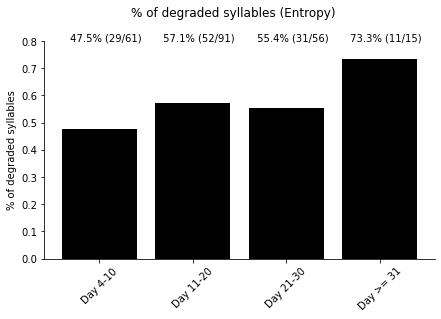

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
plt.suptitle("% of degraded syllables (Entropy)", y=1, fontsize=12)

ax.bar(range(len(sig_proportion)), sig_proportion, color='k')
ax.set_ylabel('% of degraded syllables')
ax.set_ylim([0, 0.8])
day_block_label_list = ['Day 4-10', 'Day 11-20', 'Day 21-30', 'Day >= 31']
xticks = range(len(sig_proportion))
ax.set_xticks(xticks)
ax.set_xticklabels(day_block_label_list, rotation=45)
for ind in range(len(sig_proportion)):
    ax.text(ind-0.35, ax.get_ylim()[-1], f"{sig_proportion[ind]*100 : 0.1f}% ({sig_nb_note[ind]}/{total_nb_note[ind]})", c='k', fontsize=10)
remove_right_top(ax)
plt.show()

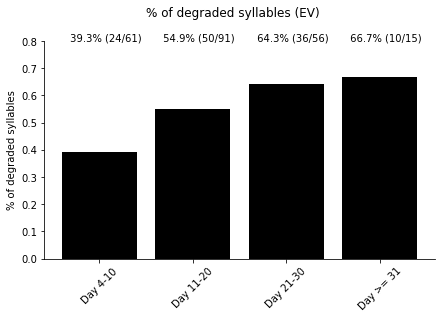

In [204]:
df_results = compare_song_feature_pre_post_per_block(db, song_feature='ev')
blocks = df_results['block10days'].unique()

total_nb_note = np.array([], dtype=np.int)
sig_nb_note = np.array([], dtype=np.int)
sig_proportion = np.array([], dtype=np.float)

for block in blocks:
    df_temp = df_results.query(f"block10days == {block}")
    total_nb_note = np.append(total_nb_note, len(df_temp))
    sig_nb_note = np.append(sig_nb_note, df_temp['sig'].sum())
    sig_proportion = np.append(sig_proportion, sig_nb_note[-1] / total_nb_note[-1])
    
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
plt.suptitle("% of degraded syllables (EV)", y=1, fontsize=12)

ax.bar(range(len(sig_proportion)), sig_proportion, color='k')
ax.set_ylabel('% of degraded syllables')
ax.set_ylim([0, 0.8])
day_block_label_list = ['Day 4-10', 'Day 11-20', 'Day 21-30', 'Day >= 31']
xticks = range(len(sig_proportion))
ax.set_xticks(xticks)
ax.set_xticklabels(day_block_label_list, rotation=45)
for ind in range(len(sig_proportion)):
    ax.text(ind-0.35, ax.get_ylim()[-1], f"{sig_proportion[ind]*100 : 0.1f}% ({sig_nb_note[ind]}/{total_nb_note[ind]})", c='k', fontsize=10)
remove_right_top(ax)
plt.show()

In [205]:
df_results

,birdID,note,nbNotes,evPre,evPost,postSessionDeafening,block10days,sig
0,b70r38,a,30,0.012,0.016,7,1,False
1,b70r38,b,29,0.005,0.007,7,1,False
2,b70r38,c,28,0.012,0.011,7,1,False
3,b70r38,d,28,0.021,0.021,7,1,False
4,b70r38,a,29,0.012,0.023,10,1,False
5,b70r38,b,29,0.005,0.012,10,1,False
6,b70r38,c,29,0.012,0.015,10,1,False
7,b70r38,d,27,0.021,0.014,10,1,True
8,w16w14,a,161,0.008,0.006,4,1,True
9,w16w14,b,103,0.019,0.016,4,1,True
